### Library

In [1]:
import json
import numpy as np
import torch
import shutil
import math
import os
import pandas as pd
import scipy.io

import torch.nn as nn 
from torchvision import datasets
from torchvision import transforms
import torchvision
from torch.optim import Optimizer
from torch.utils.data import DataLoader
from torch.nn.modules.utils import _pair, _reverse_repeat_tuple
from torch.nn.common_types import _size_2_t, _size_any_t
from torch import Tensor
from torch.nn.parameter import Parameter
from torch.nn import functional as F
from torch.nn import init
from torch.nn import Module
import torch.optim as optim

from sklearn.metrics import f1_score   

from typing import Optional, List, Tuple, Union

from tqdm.auto import tqdm
from collections import Counter
from matplotlib import pyplot as plt

### Information about class

In [2]:
cars_meta = scipy.io.loadmat('/kaggle/input/tpn-lab1/LR1-1/cars_meta.mat')
print("Information in cars_meta.mat: ", *cars_meta.keys())
class_names = [i[0] for i in cars_meta['class_names'][0]]

Information in cars_meta.mat:  __header__ __version__ __globals__ class_names


### Read data for training

In [3]:
cars_train_annos = scipy.io.loadmat('/kaggle/input/tpn-lab1/LR1-1/cars_train_annos.mat')
print("Information in cars_train_annos.mat: ", *cars_train_annos.keys())
train_class = []
train_path = []
for sample in cars_train_annos["annotations"][0]:
    train_class  += [int(sample[4][0][0])]
    train_path += [sample[5][0]]
print("Count in train: ", len(train_path ))
df_all_data = pd.DataFrame({"train_class":train_class , "train_path":train_path}).sample(frac=1).reset_index(drop=True)

Information in cars_train_annos.mat:  __header__ __version__ __globals__ annotations
Count in train:  8144


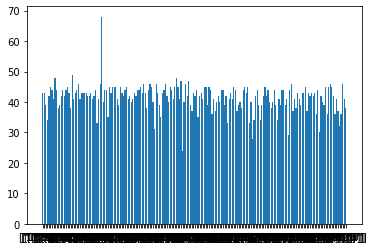

Minimum number of examples in any class:  24


In [4]:
ct = Counter([str(i) for i in train_class])
plt.bar([str(list(x)) for x in ct.keys()], ct.values())
plt.show()
print("Minimum number of examples in any class: ", min(ct.values()))

In [5]:
print("Amount of training data: ", len(train_class))
print("Expected division by train/valid", len(train_class) * 0.1)
print("Number of classes: ", len(class_names))
print("The number of representatives of each class in the validation sample: ", len(train_class) * 0.1 / len(class_names))

Amount of training data:  8144
Expected division by train/valid 814.4000000000001
Number of classes:  196
The number of representatives of each class in the validation sample:  4.155102040816327


In [6]:
train_class = []
train_path = []

valid_class = []
valid_path = []

for index, row in df_all_data.iterrows():
    if valid_class.count(row["train_class"]) <4:
        valid_class += [row["train_class"]]
        valid_path += [row["train_path"]]
    else:
        train_class += [row["train_class"]]
        train_path += [row["train_path"]] 
print(len(valid_class), len(train_class))

784 7360


In [9]:
train_class = []
train_path = []

valid_class = []
valid_path = []

with open("/kaggle/input/split-dataset-cars/train_class.txt") as f:
    train_class  = json.load(f)
with open("/kaggle/input/split-dataset-cars/train_path.txt") as f:
    train_path  = json.load(f)
with open("/kaggle/input/split-dataset-cars/valid_class.txt") as f:
    valid_class  = json.load(f)
with open("/kaggle/input/split-dataset-cars/valid_path.txt") as f:
    valid_path  = json.load(f)

In [27]:
with open("train_class.txt", "w") as f:
    f.write(json.dumps(train_class))
with open("train_path.txt", "w") as f:
    f.write(json.dumps(train_path))
with open("valid_class.txt", "w") as f:
    f.write(json.dumps(valid_class))
with open("valid_path.txt", "w") as f:
    f.write(json.dumps(valid_path))

### make folders

In [10]:
!cp /kaggle/input/tpn-lab1/LR1-1/cars_train.tgz ./
!tar -xf /kaggle/input/tpn-lab1/LR1-1/cars_train.tgz

In [11]:
os.mkdir('/kaggle/working/train/')
os.mkdir('/kaggle/working/valid/')

In [12]:
for class_name in class_names:
    class_name = class_name.replace('/', '')
    os.mkdir('/kaggle/working/train/' + class_name)
    os.mkdir('/kaggle/working/valid/' + class_name)

In [13]:
for l, img in zip(train_class, train_path):
    if l ==0:
        print(l)
    class_name = class_names[l-1].replace('/', '')
    shutil.copy('/kaggle/working/cars_train/'+img, '/kaggle/working/train/' + class_name + "/" + img)

for l, img in zip(valid_class, valid_path):
    if l ==0:
        print(l)
    class_name = class_names[l-1].replace('/', '')
    shutil.copy('/kaggle/working/cars_train/'+img, '/kaggle/working/valid/' + class_name + "/" + img)

### Optimizer

In [24]:
class AdaBound(Optimizer):

    def __init__(self, params, lr=2e-3, betas=(0.9, 0.999), final_lr=0.1, gamma=1e-4,
                 eps=1e-8, weight_decay=0, amsbound=False):
        if not 0.0 <= lr:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if not 0.0 <= eps:
            raise ValueError("Invalid epsilon value: {}".format(eps))
        if not 0.0 <= betas[0] < 1.0:
            raise ValueError("Invalid beta parameter at index 0: {}".format(betas[0]))
        if not 0.0 <= betas[1] < 1.0:
            raise ValueError("Invalid beta parameter at index 1: {}".format(betas[1]))
        if not 0.0 <= final_lr:
            raise ValueError("Invalid final learning rate: {}".format(final_lr))
        if not 0.0 <= gamma < 1.0:
            raise ValueError("Invalid gamma parameter: {}".format(gamma))
        defaults = dict(lr=lr, betas=betas, final_lr=final_lr, gamma=gamma, eps=eps,
                        weight_decay=weight_decay, amsbound=amsbound)
        super(AdaBound, self).__init__(params, defaults)

        self.base_lrs = list(map(lambda group: group['lr'], self.param_groups))

    def __setstate__(self, state):
        super(AdaBound, self).__setstate__(state)
        for group in self.param_groups:
            group.setdefault('amsbound', False)

    def step(self, closure=None):

        loss = None
        if closure is not None:
            loss = closure()

        for group, base_lr in zip(self.param_groups, self.base_lrs):
            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data
                if grad.is_sparse:
                    raise RuntimeError(
                        'Adam does not support sparse gradients, please consider SparseAdam instead')
                amsbound = group['amsbound']

                state = self.state[p]

                if len(state) == 0:
                    state['step'] = 0

                    state['exp_avg'] = torch.zeros_like(p.data)

                    state['exp_avg_sq'] = torch.zeros_like(p.data)
                    if amsbound:

                        state['max_exp_avg_sq'] = torch.zeros_like(p.data)

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                if amsbound:
                    max_exp_avg_sq = state['max_exp_avg_sq']
                beta1, beta2 = group['betas']

                state['step'] += 1

                if group['weight_decay'] != 0:
                    grad = grad.add(group['weight_decay'], p.data)

                exp_avg.mul_(beta1).add_(1 - beta1, grad)
                exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)
                if amsbound:
                    torch.max(max_exp_avg_sq, exp_avg_sq, out=max_exp_avg_sq)
                    denom = max_exp_avg_sq.sqrt().add_(group['eps'])
                else:
                    denom = exp_avg_sq.sqrt().add_(group['eps'])

                bias_correction1 = 1 - beta1 ** state['step']
                bias_correction2 = 1 - beta2 ** state['step']
                step_size = group['lr'] * math.sqrt(bias_correction2) / bias_correction1

                final_lr = group['final_lr'] * group['lr'] / base_lr
                lower_bound = final_lr * (1 - 1 / (group['gamma'] * state['step'] + 1))
                upper_bound = final_lr * (1 + 1 / (group['gamma'] * state['step']))
                step_size = torch.full_like(denom, step_size)
                step_size.div_(denom).clamp_(lower_bound, upper_bound).mul_(exp_avg)

                p.data.add_(-step_size)

        return loss

### NN

In [15]:
class _ConvNd(Module):

        __constants__ = ['stride', 'padding', 'dilation', 'groups',
                        'padding_mode', 'output_padding', 'in_channels',
                        'out_channels', 'kernel_size']
        __annotations__ = {'bias': Optional[torch.Tensor]}

        def _conv_forward(self, input: Tensor, weight: Tensor, bias: Optional[Tensor]) -> Tensor:
            ...

        in_channels: int
        _reversed_padding_repeated_twice: List[int]
        out_channels: int
        kernel_size: Tuple[int, ...]
        stride: Tuple[int, ...]
        padding: Union[str, Tuple[int, ...]]
        dilation: Tuple[int, ...]
        transposed: bool
        output_padding: Tuple[int, ...]
        groups: int
        padding_mode: str
        weight: Tensor
        bias: Optional[Tensor]
            
        def __init__(self,
                     in_channels: int, 
                     out_channels: int, 
                     kernel_size: Tuple[int, ...],
                     stride: Tuple[int, ...], 
                     padding: Tuple[int, ...],
                     dilation: Tuple[int, ...], 
                     transposed: bool, 
                     output_padding: Tuple[int, ...],
                     groups: int, bias: bool, padding_mode: str,
                     device=None,
                     dtype=None) -> None:
            factory_kwargs = {'device': device, 'dtype': dtype}
            super(_ConvNd, self).__init__()
            if groups <= 0:
                raise ValueError('groups must be a positive integer')
            if in_channels % groups != 0:
                raise ValueError('in_channels must be divisible by groups')
            if out_channels % groups != 0:
                raise ValueError('out_channels must be divisible by groups')
            valid_padding_strings = {'same', 'valid'}
            if isinstance(padding, str):
                if padding not in valid_padding_strings:
                    raise ValueError(
                        "Invalid padding string {!r}, should be one of {}".format(
                            padding, valid_padding_strings))
                if padding == 'same' and any(s != 1 for s in stride):
                    raise ValueError("padding='same' is not supported for strided convolutions")

            valid_padding_modes = {'zeros', 'reflect', 'replicate', 'circular'}
            if padding_mode not in valid_padding_modes:
                raise ValueError("padding_mode must be one of {}, but got padding_mode='{}'".format(
                    valid_padding_modes, padding_mode))
            self.in_channels = in_channels
            self.out_channels = out_channels
            self.kernel_size = kernel_size
            self.stride = stride
            self.padding = padding
            self.dilation = dilation
            self.transposed = transposed
            self.output_padding = output_padding
            self.groups = groups
            self.padding_mode = padding_mode

            if isinstance(self.padding, str):
                self._reversed_padding_repeated_twice = [0, 0] * len(kernel_size)
                if padding == 'same':
                    for d, k, i in zip(dilation, kernel_size,
                                      range(len(kernel_size) - 1, -1, -1)):
                        total_padding = d * (k - 1)
                        left_pad = total_padding // 2
                        self._reversed_padding_repeated_twice[2 * i] = left_pad
                        self._reversed_padding_repeated_twice[2 * i + 1] = (
                            total_padding - left_pad)
            else:
                self._reversed_padding_repeated_twice = _reverse_repeat_tuple(self.padding, 2)

            if transposed:
                self.weight = Parameter(torch.empty(
                    (in_channels, out_channels // groups, *kernel_size), **factory_kwargs))
            else:
                self.weight = Parameter(torch.empty(
                    (out_channels, in_channels // groups, *kernel_size), **factory_kwargs))
            if bias:
                self.bias = Parameter(torch.empty(out_channels, **factory_kwargs))
            else:
                self.register_parameter('bias', None)
            self.reset_parameters()

        def reset_parameters(self) -> None:
            init.kaiming_uniform_(self.weight, a=math.sqrt(5))
            if self.bias is not None:
                fan_in, _ = init._calculate_fan_in_and_fan_out(self.weight)
                if fan_in != 0:
                    bound = 1 / math.sqrt(fan_in)
                    init.uniform_(self.bias, -bound, bound)

        def extra_repr(self):
            s = ('{in_channels}, {out_channels}, kernel_size={kernel_size}'
                ', stride={stride}')
            if self.padding != (0,) * len(self.padding):
                s += ', padding={padding}'
            if self.dilation != (1,) * len(self.dilation):
                s += ', dilation={dilation}'
            if self.output_padding != (0,) * len(self.output_padding):
                s += ', output_padding={output_padding}'
            if self.groups != 1:
                s += ', groups={groups}'
            if self.bias is None:
                s += ', bias=False'
            if self.padding_mode != 'zeros':
                s += ', padding_mode={padding_mode}'
            return s.format(**self.__dict__)

        def __setstate__(self, state):
            super(_ConvNd, self).__setstate__(state)
            if not hasattr(self, 'padding_mode'):
                self.padding_mode = 'zeros'

In [16]:
class Conv2d(_ConvNd):
    def __init__(self, in_channels: int, out_channels: int, kernel_size: _size_2_t, stride: _size_2_t = 1, padding: Union[str, _size_2_t] = 0,
                 dilation: _size_2_t = 1, groups: int = 1, bias: bool = True,padding_mode: str = 'zeros', device=None,dtype=None) -> None:
        factory_kwargs = {'device': device, 'dtype': dtype}
        kernel_size_ = _pair(kernel_size)
        stride_ = _pair(stride)
        padding_ = padding if isinstance(padding, str) else _pair(padding)
        dilation_ = _pair(dilation)
        super(Conv2d, self).__init__(in_channels, out_channels, kernel_size_, stride_, padding_, dilation_,
                                     False, _pair(0), groups, bias, padding_mode, **factory_kwargs)

    def _conv_forward(self, input: Tensor, weight: Tensor, bias: Optional[Tensor]):
        if self.padding_mode != 'zeros':
            return F.conv2d(F.pad(input, self._reversed_padding_repeated_twice, mode=self.padding_mode),
                                weight, bias, self.stride,
                                _pair(0), self.dilation, self.groups)
        return F.conv2d(input, weight, bias, self.stride,
                            self.padding, self.dilation, self.groups)

    def forward(self, input: Tensor) -> Tensor:
        return self._conv_forward(input, self.weight, self.bias)

In [17]:
class Linear(Module):
    __constants__ = ['in_features', 'out_features']
    in_features: int
    out_features: int
    weight: Tensor

    def __init__(self, in_features: int, out_features: int, bias: bool = True,
                 device=None, dtype=None) -> None:
        factory_kwargs = {'device': device, 'dtype': dtype}
        super(Linear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weight = Parameter(torch.empty((out_features, in_features), **factory_kwargs))
        if bias:
            self.bias = Parameter(torch.empty(out_features, **factory_kwargs))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()

    def reset_parameters(self) -> None:
        init.kaiming_uniform_(self.weight, a=math.sqrt(5))
        if self.bias is not None:
            fan_in, _ = init._calculate_fan_in_and_fan_out(self.weight)
            bound = 1 / math.sqrt(fan_in) if fan_in > 0 else 0
            init.uniform_(self.bias, -bound, bound)

    def forward(self, input: Tensor) -> Tensor:
        return F.linear(input, self.weight, self.bias)

    def extra_repr(self) -> str:
        return 'in_features={}, out_features={}, bias={}'.format(
            self.in_features, self.out_features, self.bias is not None
        )

In [18]:
class _Loss(Module):
    reduction: str

    def __init__(self, size_average=None, reduce=None, reduction: str = 'mean') -> None:
        super(_Loss, self).__init__()
        if size_average is not None or reduce is not None:
            self.reduction: str = _Reduction.legacy_get_string(size_average, reduce)
        else:
            self.reduction = reduction

class _WeightedLoss(_Loss):
    def __init__(self, weight: Optional[Tensor] = None, size_average=None, reduce=None, reduction: str = 'mean') -> None:
        super(_WeightedLoss, self).__init__(size_average, reduce, reduction)
        self.register_buffer('weight', weight)
        self.weight: Optional[Tensor]

class CrossEntropyLoss(_WeightedLoss):
    __constants__ = ['ignore_index', 'reduction', 'label_smoothing']
    ignore_index: int
    label_smoothing: float

    def __init__(self, weight: Optional[Tensor] = None, size_average=None, ignore_index: int = -100,
                 reduce=None, reduction: str = 'mean', label_smoothing: float = 0.0) -> None:
        super(CrossEntropyLoss, self).__init__(weight, size_average, reduce, reduction)
        self.ignore_index = ignore_index
        self.label_smoothing = label_smoothing

    def forward(self, input: Tensor, target: Tensor) -> Tensor:
        return F.cross_entropy(input, target, weight=self.weight,
                               ignore_index=self.ignore_index, reduction=self.reduction,
                               label_smoothing=self.label_smoothing)

In [19]:
class _MaxPoolNd(Module):
    __constants__ = ['kernel_size', 'stride', 'padding', 'dilation',
                     'return_indices', 'ceil_mode']
    return_indices: bool
    ceil_mode: bool

    def __init__(self, kernel_size: _size_any_t, stride: Optional[_size_any_t] = None,
                 padding: _size_any_t = 0, dilation: _size_any_t = 1,
                 return_indices: bool = False, ceil_mode: bool = False) -> None:
        super(_MaxPoolNd, self).__init__()
        self.kernel_size = kernel_size
        self.stride = stride if (stride is not None) else kernel_size
        self.padding = padding
        self.dilation = dilation
        self.return_indices = return_indices
        self.ceil_mode = ceil_mode

    def extra_repr(self) -> str:
        return 'kernel_size={kernel_size}, stride={stride}, padding={padding}' \
            ', dilation={dilation}, ceil_mode={ceil_mode}'.format(**self.__dict__)

class MaxPool2d(_MaxPoolNd):
    kernel_size: _size_2_t
    stride: _size_2_t
    padding: _size_2_t
    dilation: _size_2_t

    def forward(self, input: Tensor):
        return F.max_pool2d(input, self.kernel_size, self.stride,
                            self.padding, self.dilation, ceil_mode=self.ceil_mode,
                            return_indices=self.return_indices)

In [20]:
class ReLU(Module):
    __constants__ = ['inplace']
    inplace: bool

    def __init__(self, inplace: bool = False):
        super(ReLU, self).__init__()
        self.inplace = inplace

    def forward(self, input: Tensor) -> Tensor:
        return F.relu(input, inplace=self.inplace)

    def extra_repr(self) -> str:
        inplace_str = 'inplace=True' if self.inplace else ''
        return inplace_str

In [21]:
class VGG16(Module):

    def __init__(self, num_classes=10, shrink=7):
        super(VGG16, self).__init__()

        self.layer1 = nn.Sequential(
            Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            ReLU())
        
        self.layer2 = nn.Sequential(
            Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            ReLU(), 
            MaxPool2d(kernel_size = 2, stride = 2))
        
        self.layer3 = nn.Sequential(
            Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            ReLU())
        self.layer4 = nn.Sequential(
            Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            ReLU(),
            MaxPool2d(kernel_size = 2, stride = 2))
        
        self.layer5 = nn.Sequential(
            Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            ReLU())
        
        self.layer6 = nn.Sequential(
            Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            ReLU())
        
        self.layer7 = nn.Sequential(
            Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            ReLU(),
            MaxPool2d(kernel_size = 2, stride = 2))
        
        self.layer8 = nn.Sequential(
            Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            ReLU())
        
        self.layer9 = nn.Sequential(
            Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            ReLU())
        
        self.layer10 = nn.Sequential(
            Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            ReLU(),
            MaxPool2d(kernel_size = 2, stride = 2))
        
        self.layer11 = nn.Sequential(
            Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            ReLU())
        
        self.layer12 = nn.Sequential(
            Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            ReLU())
        
        self.layer13 = nn.Sequential(
            Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            ReLU(),
            MaxPool2d(kernel_size = 2, stride = 2))
        
        self.fc = nn.Sequential(
            Linear(shrink*shrink*512, 4096),
            ReLU())
        
        self.fc1 = nn.Sequential(
            Linear(4096, 4096),
            ReLU())
        
        self.fc2= nn.Sequential(
            Linear(4096, num_classes))
        
    def forward(self, x):
        out = self.layer1.forward(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = self.layer6(out)
        out = self.layer7(out)
        out = self.layer8(out)
        out = self.layer9(out)
        out = self.layer10(out)
        out = self.layer11(out)
        out = self.layer12(out)
        out = self.layer13(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        out = self.fc1(out)
        out = self.fc2(out)

        return out


### Prepare data

In [22]:
train_dir = "/kaggle/working/train"
valid_dir = "/kaggle/working/valid"
image_size = 224
batch_size = 350
num_workers = 2
epochs = 100
lr = 0.0001

train_transform = transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(35),
        transforms.RandomAdjustSharpness(sharpness_factor=2, p=0.5),
        transforms.RandomGrayscale(p=0.5),
        transforms.RandomPerspective(distortion_scale=0.5, p=0.5),
        transforms.RandomPosterize(bits=2, p=0.5),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
            )
    ])
valid_transform = transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
            )
    ])


dataset_train = datasets.ImageFolder(
        train_dir, 
        transform=(train_transform))
dataset_valid = datasets.ImageFolder(
        valid_dir, 
        transform=(valid_transform))


train_data_loader = DataLoader(
        dataset_train, batch_size=batch_size, 
        shuffle=True, num_workers=num_workers)
valid_data_loader = DataLoader(
        dataset_valid, batch_size=batch_size, 
        shuffle=False, num_workers=num_workers)

### Train data #1 (Adam)

In [26]:
model = torchvision.models.vgg16(pretrained=True)
for param in model.parameters():
    param.requires_grad = False
num_ftrs = model.classifier[-1].in_features
model.classifier[-1] = Linear(num_ftrs, 196)
model.classifier[-4] = Linear(4096, 4096)
model.classifier[-7] = Linear(25088, 4096)




device = ('cuda' if torch.cuda.is_available() else 'cpu')
optimizer = optim.Adam(model.parameters(), lr=lr)

criterion = CrossEntropyLoss()

model = model.to(device)

train_loss, valid_loss, train_acc, valid_acc, f1_valid = [], [], [], [], []
for epoch in range(epochs):
    print(f"Epoch {epoch+1} of {epochs}")

    
    model.train()
    print('Start training')
    train_running_loss = 0.0
    train_running_correct = 0
    for i, data in tqdm(enumerate(train_data_loader), total=len(train_data_loader)):
        image, labels = data
        image = image.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(image)
        loss = criterion(outputs, labels)
        train_running_loss += loss.item()
        _, preds = torch.max(outputs.data, 1)
        train_running_correct += (preds == labels).sum().item()
        loss.backward()
        optimizer.step()

    train_epoch_loss = train_running_loss / len(train_data_loader)
    train_epoch_acc = 100. * (train_running_correct / len(train_data_loader.dataset))
    
    print(f"Training loss: {train_epoch_loss:.3f}, training acc: {train_epoch_acc:.3f}")
    

    model.eval()
    print('Start validation')
    valid_running_loss = 0.0
    valid_running_correct = 0
    y_preds, y_true = [], []
    with torch.no_grad():
        for i, data in tqdm(enumerate(valid_data_loader), total=len(valid_data_loader)):
            image, labels = data
            image = image.to(device)
            labels = labels.to(device)
            outputs = model(image)
            loss = criterion(outputs, labels)
            valid_running_loss += loss.item()
            _, preds = torch.max(outputs.data, 1)
            y_preds.extend(preds.cpu())
            y_true.extend(labels.data.cpu())
            valid_running_correct += (preds == labels).sum().item()

    valid_epoch_loss = valid_running_loss / len(valid_data_loader)
    valid_epoch_acc = 100. * (valid_running_correct / len(valid_data_loader.dataset))
    f1_e = f1_score(np.array(y_true), np.array(y_preds), average='macro')   
    
    print(f"Validation loss: {valid_epoch_loss:.3f}, validation acc: {valid_epoch_acc:.3f}")
    print(f"f1 for epoch: {f1_e}")
    
    train_loss.append(train_epoch_loss)
    valid_loss.append(valid_epoch_loss)
    f1_valid.append(f1_e)
    train_acc.append(train_epoch_acc)
    valid_acc.append(valid_epoch_acc)

    with open("adam_train_loss.txt", "w") as f:
        f.write(json.dumps(train_loss))
    with open("adam_valid_loss.txt", "w") as f:
        f.write(json.dumps(valid_loss))
    with open("adam_train_acc.txt", "w") as f:
        f.write(json.dumps(train_acc))
    with open("adam_valid_acc.txt", "w") as f:
        f.write(json.dumps(valid_acc))
    with open("adam_f1_valid.txt", "w") as f:
        f.write(json.dumps(f1_valid))
    
    print("____________________")

Epoch 1 of 100
Start training


  0%|          | 0/22 [00:00<?, ?it/s]

Training loss: 5.324, training acc: 0.571
Start validation


  0%|          | 0/3 [00:00<?, ?it/s]

Validation loss: 5.234, validation acc: 0.638
f1 for epoch: 0.0008868433546671847
____________________
Epoch 2 of 100
Start training


  0%|          | 0/22 [00:00<?, ?it/s]

Training loss: 5.260, training acc: 0.938
Start validation


  0%|          | 0/3 [00:00<?, ?it/s]

Validation loss: 5.144, validation acc: 1.403
f1 for epoch: 0.004506635623209077
____________________
Epoch 3 of 100
Start training


  0%|          | 0/22 [00:00<?, ?it/s]

Training loss: 5.225, training acc: 1.454
Start validation


  0%|          | 0/3 [00:00<?, ?it/s]

Validation loss: 5.038, validation acc: 3.571
f1 for epoch: 0.01758936294195125
____________________
Epoch 4 of 100
Start training


  0%|          | 0/22 [00:00<?, ?it/s]

Training loss: 5.135, training acc: 1.943
Start validation


  0%|          | 0/3 [00:00<?, ?it/s]

Validation loss: 4.896, validation acc: 3.316
f1 for epoch: 0.00802255710881628
____________________
Epoch 5 of 100
Start training


  0%|          | 0/22 [00:00<?, ?it/s]

Training loss: 5.015, training acc: 2.242
Start validation


  0%|          | 0/3 [00:00<?, ?it/s]

Validation loss: 4.688, validation acc: 3.954
f1 for epoch: 0.015532855403413922
____________________
Epoch 6 of 100
Start training


  0%|          | 0/22 [00:00<?, ?it/s]

Training loss: 4.924, training acc: 2.459
Start validation


  0%|          | 0/3 [00:00<?, ?it/s]

Validation loss: 4.508, validation acc: 7.143
f1 for epoch: 0.03985668577334897
____________________
Epoch 7 of 100
Start training


  0%|          | 0/22 [00:00<?, ?it/s]

Training loss: 4.805, training acc: 3.465
Start validation


  0%|          | 0/3 [00:00<?, ?it/s]

Validation loss: 4.366, validation acc: 5.102
f1 for epoch: 0.0305234696070466
____________________
Epoch 8 of 100
Start training


  0%|          | 0/22 [00:00<?, ?it/s]

Training loss: 4.717, training acc: 3.859
Start validation


  0%|          | 0/3 [00:00<?, ?it/s]

Validation loss: 4.255, validation acc: 8.546
f1 for epoch: 0.050699893731719334
____________________
Epoch 9 of 100
Start training


  0%|          | 0/22 [00:00<?, ?it/s]

Training loss: 4.649, training acc: 4.688
Start validation


  0%|          | 0/3 [00:00<?, ?it/s]

Validation loss: 4.128, validation acc: 8.673
f1 for epoch: 0.0554106105127132
____________________
Epoch 10 of 100
Start training


  0%|          | 0/22 [00:00<?, ?it/s]

Training loss: 4.540, training acc: 5.584
Start validation


  0%|          | 0/3 [00:00<?, ?it/s]

Validation loss: 4.030, validation acc: 10.077
f1 for epoch: 0.05951391305508576
____________________
Epoch 11 of 100
Start training


  0%|          | 0/22 [00:00<?, ?it/s]

Training loss: 4.497, training acc: 6.223
Start validation


  0%|          | 0/3 [00:00<?, ?it/s]

Validation loss: 3.895, validation acc: 10.332
f1 for epoch: 0.07033043974919491
____________________
Epoch 12 of 100
Start training


  0%|          | 0/22 [00:00<?, ?it/s]

Training loss: 4.393, training acc: 6.916
Start validation


  0%|          | 0/3 [00:00<?, ?it/s]

Validation loss: 3.837, validation acc: 10.842
f1 for epoch: 0.07455821484924545
____________________
Epoch 13 of 100
Start training


  0%|          | 0/22 [00:00<?, ?it/s]

Training loss: 4.350, training acc: 8.057
Start validation


  0%|          | 0/3 [00:00<?, ?it/s]

Validation loss: 3.752, validation acc: 13.393
f1 for epoch: 0.0994256973518678
____________________
Epoch 14 of 100
Start training


  0%|          | 0/22 [00:00<?, ?it/s]

Training loss: 4.245, training acc: 8.995
Start validation


  0%|          | 0/3 [00:00<?, ?it/s]

Validation loss: 3.678, validation acc: 14.796
f1 for epoch: 0.11052608338683186
____________________
Epoch 15 of 100
Start training


  0%|          | 0/22 [00:00<?, ?it/s]

Training loss: 4.217, training acc: 9.008
Start validation


  0%|          | 0/3 [00:00<?, ?it/s]

Validation loss: 3.618, validation acc: 11.990
f1 for epoch: 0.09416869078847684
____________________
Epoch 16 of 100
Start training


  0%|          | 0/22 [00:00<?, ?it/s]

Training loss: 4.151, training acc: 9.715
Start validation


  0%|          | 0/3 [00:00<?, ?it/s]

Validation loss: 3.495, validation acc: 16.327
f1 for epoch: 0.1270648122981951
____________________
Epoch 17 of 100
Start training


  0%|          | 0/22 [00:00<?, ?it/s]

Training loss: 4.085, training acc: 10.435
Start validation


  0%|          | 0/3 [00:00<?, ?it/s]

Validation loss: 3.461, validation acc: 17.857
f1 for epoch: 0.13329634853168976
____________________
Epoch 18 of 100
Start training


  0%|          | 0/22 [00:00<?, ?it/s]

Training loss: 4.060, training acc: 11.128
Start validation


  0%|          | 0/3 [00:00<?, ?it/s]

Validation loss: 3.396, validation acc: 18.112
f1 for epoch: 0.14897799678261872
____________________
Epoch 19 of 100
Start training


  0%|          | 0/22 [00:00<?, ?it/s]

Training loss: 4.010, training acc: 11.671
Start validation


  0%|          | 0/3 [00:00<?, ?it/s]

Validation loss: 3.364, validation acc: 18.240
f1 for epoch: 0.15071050430872457
____________________
Epoch 20 of 100
Start training


  0%|          | 0/22 [00:00<?, ?it/s]

Training loss: 3.939, training acc: 12.704
Start validation


  0%|          | 0/3 [00:00<?, ?it/s]

Validation loss: 3.307, validation acc: 19.133
f1 for epoch: 0.1629867051451058
____________________
Epoch 21 of 100
Start training


  0%|          | 0/22 [00:00<?, ?it/s]

Training loss: 3.889, training acc: 13.641
Start validation


  0%|          | 0/3 [00:00<?, ?it/s]

Validation loss: 3.287, validation acc: 21.301
f1 for epoch: 0.1820509684652304
____________________
Epoch 22 of 100
Start training


  0%|          | 0/22 [00:00<?, ?it/s]

Training loss: 3.883, training acc: 13.723
Start validation


  0%|          | 0/3 [00:00<?, ?it/s]

Validation loss: 3.194, validation acc: 21.429
f1 for epoch: 0.1800994745085934
____________________
Epoch 23 of 100
Start training


  0%|          | 0/22 [00:00<?, ?it/s]

Training loss: 3.876, training acc: 13.764
Start validation


  0%|          | 0/3 [00:00<?, ?it/s]

Validation loss: 3.150, validation acc: 22.066
f1 for epoch: 0.1824026071899134
____________________
Epoch 24 of 100
Start training


  0%|          | 0/22 [00:00<?, ?it/s]

Training loss: 3.819, training acc: 14.674
Start validation


  0%|          | 0/3 [00:00<?, ?it/s]

Validation loss: 3.145, validation acc: 21.556
f1 for epoch: 0.17752901522337214
____________________
Epoch 25 of 100
Start training


  0%|          | 0/22 [00:00<?, ?it/s]

Training loss: 3.732, training acc: 14.837
Start validation


  0%|          | 0/3 [00:00<?, ?it/s]

Validation loss: 3.081, validation acc: 24.235
f1 for epoch: 0.21199025923554116
____________________
Epoch 26 of 100
Start training


  0%|          | 0/22 [00:00<?, ?it/s]

Training loss: 3.731, training acc: 16.141
Start validation


  0%|          | 0/3 [00:00<?, ?it/s]

Validation loss: 3.064, validation acc: 23.852
f1 for epoch: 0.2084211490123855
____________________
Epoch 27 of 100
Start training


  0%|          | 0/22 [00:00<?, ?it/s]

Training loss: 3.699, training acc: 15.842
Start validation


  0%|          | 0/3 [00:00<?, ?it/s]

Validation loss: 3.018, validation acc: 25.510
f1 for epoch: 0.21914514742982227
____________________
Epoch 28 of 100
Start training


  0%|          | 0/22 [00:00<?, ?it/s]

Training loss: 3.657, training acc: 16.766
Start validation


  0%|          | 0/3 [00:00<?, ?it/s]

Validation loss: 2.987, validation acc: 23.980
f1 for epoch: 0.2097133919603039
____________________
Epoch 29 of 100
Start training


  0%|          | 0/22 [00:00<?, ?it/s]

Training loss: 3.647, training acc: 17.418
Start validation


  0%|          | 0/3 [00:00<?, ?it/s]

Validation loss: 2.943, validation acc: 25.383
f1 for epoch: 0.21518216094296524
____________________
Epoch 30 of 100
Start training


  0%|          | 0/22 [00:00<?, ?it/s]

Training loss: 3.608, training acc: 17.921
Start validation


  0%|          | 0/3 [00:00<?, ?it/s]

Validation loss: 2.943, validation acc: 25.510
f1 for epoch: 0.22348091844236984
____________________
Epoch 31 of 100
Start training


  0%|          | 0/22 [00:00<?, ?it/s]

Training loss: 3.564, training acc: 18.927
Start validation


  0%|          | 0/3 [00:00<?, ?it/s]

Validation loss: 2.912, validation acc: 25.765
f1 for epoch: 0.22914017109774365
____________________
Epoch 32 of 100
Start training


  0%|          | 0/22 [00:00<?, ?it/s]

Training loss: 3.547, training acc: 18.777
Start validation


  0%|          | 0/3 [00:00<?, ?it/s]

Validation loss: 2.848, validation acc: 27.168
f1 for epoch: 0.2351445329082437
____________________
Epoch 33 of 100
Start training


  0%|          | 0/22 [00:00<?, ?it/s]

Training loss: 3.493, training acc: 19.728
Start validation


  0%|          | 0/3 [00:00<?, ?it/s]

Validation loss: 2.781, validation acc: 28.316
f1 for epoch: 0.2556172269107443
____________________
Epoch 34 of 100
Start training


  0%|          | 0/22 [00:00<?, ?it/s]

Training loss: 3.479, training acc: 19.783
Start validation


  0%|          | 0/3 [00:00<?, ?it/s]

Validation loss: 2.831, validation acc: 27.551
f1 for epoch: 0.2416129308431882
____________________
Epoch 35 of 100
Start training


  0%|          | 0/22 [00:00<?, ?it/s]

Training loss: 3.462, training acc: 19.647
Start validation


  0%|          | 0/3 [00:00<?, ?it/s]

Validation loss: 2.826, validation acc: 29.464
f1 for epoch: 0.27009968724545286
____________________
Epoch 36 of 100
Start training


  0%|          | 0/22 [00:00<?, ?it/s]

Training loss: 3.426, training acc: 20.367
Start validation


  0%|          | 0/3 [00:00<?, ?it/s]

Validation loss: 2.831, validation acc: 27.806
f1 for epoch: 0.24522728855797893
____________________
Epoch 37 of 100
Start training


  0%|          | 0/22 [00:00<?, ?it/s]

Training loss: 3.379, training acc: 21.386
Start validation


  0%|          | 0/3 [00:00<?, ?it/s]

Validation loss: 2.793, validation acc: 28.444
f1 for epoch: 0.2586997330589944
____________________
Epoch 38 of 100
Start training


  0%|          | 0/22 [00:00<?, ?it/s]

Training loss: 3.333, training acc: 21.766
Start validation


  0%|          | 0/3 [00:00<?, ?it/s]

Validation loss: 2.795, validation acc: 28.699
f1 for epoch: 0.27092469502052735
____________________
Epoch 39 of 100
Start training


  0%|          | 0/22 [00:00<?, ?it/s]

Training loss: 3.343, training acc: 22.486
Start validation


  0%|          | 0/3 [00:00<?, ?it/s]

Validation loss: 2.791, validation acc: 30.357
f1 for epoch: 0.27386773491491695
____________________
Epoch 40 of 100
Start training


  0%|          | 0/22 [00:00<?, ?it/s]

Training loss: 3.306, training acc: 22.242
Start validation


  0%|          | 0/3 [00:00<?, ?it/s]

Validation loss: 2.817, validation acc: 27.679
f1 for epoch: 0.25471521452307655
____________________
Epoch 41 of 100
Start training


  0%|          | 0/22 [00:00<?, ?it/s]

Training loss: 3.298, training acc: 23.682
Start validation


  0%|          | 0/3 [00:00<?, ?it/s]

Validation loss: 2.761, validation acc: 30.230
f1 for epoch: 0.2823271668062216
____________________
Epoch 42 of 100
Start training


  0%|          | 0/22 [00:00<?, ?it/s]

Training loss: 3.337, training acc: 22.120
Start validation


  0%|          | 0/3 [00:00<?, ?it/s]

Validation loss: 2.745, validation acc: 28.571
f1 for epoch: 0.2642925715669184
____________________
Epoch 43 of 100
Start training


  0%|          | 0/22 [00:00<?, ?it/s]

Training loss: 3.291, training acc: 22.731
Start validation


  0%|          | 0/3 [00:00<?, ?it/s]

Validation loss: 2.706, validation acc: 31.250
f1 for epoch: 0.2915040905508145
____________________
Epoch 44 of 100
Start training


  0%|          | 0/22 [00:00<?, ?it/s]

Training loss: 3.226, training acc: 24.416
Start validation


  0%|          | 0/3 [00:00<?, ?it/s]

Validation loss: 2.767, validation acc: 29.209
f1 for epoch: 0.26827178974656385
____________________
Epoch 45 of 100
Start training


  0%|          | 0/22 [00:00<?, ?it/s]

Training loss: 3.221, training acc: 24.905
Start validation


  0%|          | 0/3 [00:00<?, ?it/s]

Validation loss: 2.704, validation acc: 30.230
f1 for epoch: 0.2818662686242897
____________________
Epoch 46 of 100
Start training


  0%|          | 0/22 [00:00<?, ?it/s]

Training loss: 3.211, training acc: 24.280
Start validation


  0%|          | 0/3 [00:00<?, ?it/s]

Validation loss: 2.649, validation acc: 32.398
f1 for epoch: 0.2943226776312642
____________________
Epoch 47 of 100
Start training


  0%|          | 0/22 [00:00<?, ?it/s]

Training loss: 3.223, training acc: 25.163
Start validation


  0%|          | 0/3 [00:00<?, ?it/s]

Validation loss: 2.579, validation acc: 32.270
f1 for epoch: 0.2992067207364533
____________________
Epoch 48 of 100
Start training


  0%|          | 0/22 [00:00<?, ?it/s]

Training loss: 3.188, training acc: 25.679
Start validation


  0%|          | 0/3 [00:00<?, ?it/s]

Validation loss: 2.663, validation acc: 31.760
f1 for epoch: 0.2905775322841062
____________________
Epoch 49 of 100
Start training


  0%|          | 0/22 [00:00<?, ?it/s]

Training loss: 3.184, training acc: 25.693
Start validation


  0%|          | 0/3 [00:00<?, ?it/s]

Validation loss: 2.680, validation acc: 31.888
f1 for epoch: 0.3010093548021792
____________________
Epoch 50 of 100
Start training


  0%|          | 0/22 [00:00<?, ?it/s]

Training loss: 3.180, training acc: 25.258
Start validation


  0%|          | 0/3 [00:00<?, ?it/s]

Validation loss: 2.608, validation acc: 31.760
f1 for epoch: 0.29076289273618205
____________________
Epoch 51 of 100
Start training


  0%|          | 0/22 [00:00<?, ?it/s]

Training loss: 3.088, training acc: 26.535
Start validation


  0%|          | 0/3 [00:00<?, ?it/s]

Validation loss: 2.559, validation acc: 35.587
f1 for epoch: 0.3344441964264893
____________________
Epoch 52 of 100
Start training


  0%|          | 0/22 [00:00<?, ?it/s]

Training loss: 3.099, training acc: 26.630
Start validation


  0%|          | 0/3 [00:00<?, ?it/s]

Validation loss: 2.625, validation acc: 33.163
f1 for epoch: 0.31555101613704
____________________
Epoch 53 of 100
Start training


  0%|          | 0/22 [00:00<?, ?it/s]

Training loss: 3.098, training acc: 26.372
Start validation


  0%|          | 0/3 [00:00<?, ?it/s]

Validation loss: 2.538, validation acc: 34.949
f1 for epoch: 0.3265072479208133
____________________
Epoch 54 of 100
Start training


  0%|          | 0/22 [00:00<?, ?it/s]

Training loss: 3.089, training acc: 26.916
Start validation


  0%|          | 0/3 [00:00<?, ?it/s]

Validation loss: 2.596, validation acc: 32.398
f1 for epoch: 0.30112689865176673
____________________
Epoch 55 of 100
Start training


  0%|          | 0/22 [00:00<?, ?it/s]

Training loss: 3.067, training acc: 27.582
Start validation


  0%|          | 0/3 [00:00<?, ?it/s]

Validation loss: 2.539, validation acc: 34.311
f1 for epoch: 0.31059467471374336
____________________
Epoch 56 of 100
Start training


  0%|          | 0/22 [00:00<?, ?it/s]

Training loss: 3.009, training acc: 28.397
Start validation


  0%|          | 0/3 [00:00<?, ?it/s]

Validation loss: 2.525, validation acc: 36.097
f1 for epoch: 0.32962702396976107
____________________
Epoch 57 of 100
Start training


  0%|          | 0/22 [00:00<?, ?it/s]

Training loss: 2.938, training acc: 28.886
Start validation


  0%|          | 0/3 [00:00<?, ?it/s]

Validation loss: 2.548, validation acc: 33.163
f1 for epoch: 0.30683709319631075
____________________
Epoch 58 of 100
Start training


  0%|          | 0/22 [00:00<?, ?it/s]

Training loss: 2.949, training acc: 29.198
Start validation


  0%|          | 0/3 [00:00<?, ?it/s]

Validation loss: 2.472, validation acc: 36.607
f1 for epoch: 0.3411442835717809
____________________
Epoch 59 of 100
Start training


  0%|          | 0/22 [00:00<?, ?it/s]

Training loss: 2.950, training acc: 28.234
Start validation


  0%|          | 0/3 [00:00<?, ?it/s]

Validation loss: 2.521, validation acc: 33.673
f1 for epoch: 0.31370938835951157
____________________
Epoch 60 of 100
Start training


  0%|          | 0/22 [00:00<?, ?it/s]

Training loss: 2.943, training acc: 29.470
Start validation


  0%|          | 0/3 [00:00<?, ?it/s]

Validation loss: 2.487, validation acc: 36.224
f1 for epoch: 0.33867761376993333
____________________
Epoch 61 of 100
Start training


  0%|          | 0/22 [00:00<?, ?it/s]

Training loss: 2.939, training acc: 29.606
Start validation


  0%|          | 0/3 [00:00<?, ?it/s]

Validation loss: 2.514, validation acc: 35.332
f1 for epoch: 0.3319527353065768
____________________
Epoch 62 of 100
Start training


  0%|          | 0/22 [00:00<?, ?it/s]

Training loss: 2.892, training acc: 30.679
Start validation


  0%|          | 0/3 [00:00<?, ?it/s]

Validation loss: 2.461, validation acc: 37.245
f1 for epoch: 0.3487605365156386
____________________
Epoch 63 of 100
Start training


  0%|          | 0/22 [00:00<?, ?it/s]

Training loss: 2.887, training acc: 30.136
Start validation


  0%|          | 0/3 [00:00<?, ?it/s]

Validation loss: 2.483, validation acc: 37.755
f1 for epoch: 0.3582982091306474
____________________
Epoch 64 of 100
Start training


  0%|          | 0/22 [00:00<?, ?it/s]

Training loss: 2.852, training acc: 31.427
Start validation


  0%|          | 0/3 [00:00<?, ?it/s]

Validation loss: 2.493, validation acc: 37.500
f1 for epoch: 0.3565841679662207
____________________
Epoch 65 of 100
Start training


  0%|          | 0/22 [00:00<?, ?it/s]

Training loss: 2.880, training acc: 30.856
Start validation


  0%|          | 0/3 [00:00<?, ?it/s]

Validation loss: 2.488, validation acc: 36.224
f1 for epoch: 0.3421643638614637
____________________
Epoch 66 of 100
Start training


  0%|          | 0/22 [00:00<?, ?it/s]

Training loss: 2.826, training acc: 31.617
Start validation


  0%|          | 0/3 [00:00<?, ?it/s]

Validation loss: 2.464, validation acc: 35.587
f1 for epoch: 0.34168248701411963
____________________
Epoch 67 of 100
Start training


  0%|          | 0/22 [00:00<?, ?it/s]

Training loss: 2.789, training acc: 32.323
Start validation


  0%|          | 0/3 [00:00<?, ?it/s]

Validation loss: 2.520, validation acc: 36.352
f1 for epoch: 0.35458160786792237
____________________
Epoch 68 of 100
Start training


  0%|          | 0/22 [00:00<?, ?it/s]

Training loss: 2.779, training acc: 31.902
Start validation


  0%|          | 0/3 [00:00<?, ?it/s]

Validation loss: 2.514, validation acc: 35.969
f1 for epoch: 0.3470987914593777
____________________
Epoch 69 of 100
Start training


  0%|          | 0/22 [00:00<?, ?it/s]

Training loss: 2.815, training acc: 32.582
Start validation


  0%|          | 0/3 [00:00<?, ?it/s]

Validation loss: 2.484, validation acc: 37.117
f1 for epoch: 0.35665907055462875
____________________
Epoch 70 of 100
Start training


  0%|          | 0/22 [00:00<?, ?it/s]

Training loss: 2.777, training acc: 32.622
Start validation


  0%|          | 0/3 [00:00<?, ?it/s]

Validation loss: 2.483, validation acc: 37.500
f1 for epoch: 0.3561735158598904
____________________
Epoch 71 of 100
Start training


  0%|          | 0/22 [00:00<?, ?it/s]

Training loss: 2.738, training acc: 33.098
Start validation


  0%|          | 0/3 [00:00<?, ?it/s]

Validation loss: 2.453, validation acc: 38.138
f1 for epoch: 0.36143522677136114
____________________
Epoch 72 of 100
Start training


  0%|          | 0/22 [00:00<?, ?it/s]

Training loss: 2.698, training acc: 33.410
Start validation


  0%|          | 0/3 [00:00<?, ?it/s]

Validation loss: 2.461, validation acc: 35.587
f1 for epoch: 0.3377640962093164
____________________
Epoch 73 of 100
Start training


  0%|          | 0/22 [00:00<?, ?it/s]

Training loss: 2.697, training acc: 33.927
Start validation


  0%|          | 0/3 [00:00<?, ?it/s]

Validation loss: 2.473, validation acc: 36.735
f1 for epoch: 0.3419894876645998
____________________
Epoch 74 of 100
Start training


  0%|          | 0/22 [00:00<?, ?it/s]

Training loss: 2.710, training acc: 32.840
Start validation


  0%|          | 0/3 [00:00<?, ?it/s]

Validation loss: 2.410, validation acc: 37.117
f1 for epoch: 0.35362245315252827
____________________
Epoch 75 of 100
Start training


  0%|          | 0/22 [00:00<?, ?it/s]

Training loss: 2.708, training acc: 34.348
Start validation


  0%|          | 0/3 [00:00<?, ?it/s]

Validation loss: 2.427, validation acc: 37.628
f1 for epoch: 0.35155664330334196
____________________
Epoch 76 of 100
Start training


  0%|          | 0/22 [00:00<?, ?it/s]

Training loss: 2.622, training acc: 35.014
Start validation


  0%|          | 0/3 [00:00<?, ?it/s]

Validation loss: 2.426, validation acc: 37.500
f1 for epoch: 0.35188770830553856
____________________
Epoch 77 of 100
Start training


  0%|          | 0/22 [00:00<?, ?it/s]

Training loss: 2.683, training acc: 34.592
Start validation


  0%|          | 0/3 [00:00<?, ?it/s]

Validation loss: 2.423, validation acc: 38.393
f1 for epoch: 0.3602265631527336
____________________
Epoch 78 of 100
Start training


  0%|          | 0/22 [00:00<?, ?it/s]

Training loss: 2.602, training acc: 35.408
Start validation


  0%|          | 0/3 [00:00<?, ?it/s]

Validation loss: 2.396, validation acc: 38.393
f1 for epoch: 0.3603231785554714
____________________
Epoch 79 of 100
Start training


  0%|          | 0/22 [00:00<?, ?it/s]

Training loss: 2.634, training acc: 35.258
Start validation


  0%|          | 0/3 [00:00<?, ?it/s]

Validation loss: 2.430, validation acc: 38.138
f1 for epoch: 0.3609398821133515
____________________
Epoch 80 of 100
Start training


  0%|          | 0/22 [00:00<?, ?it/s]

Training loss: 2.596, training acc: 35.761
Start validation


  0%|          | 0/3 [00:00<?, ?it/s]

Validation loss: 2.414, validation acc: 37.755
f1 for epoch: 0.35777220268010296
____________________
Epoch 81 of 100
Start training


  0%|          | 0/22 [00:00<?, ?it/s]

Training loss: 2.593, training acc: 35.856
Start validation


  0%|          | 0/3 [00:00<?, ?it/s]

Validation loss: 2.396, validation acc: 39.031
f1 for epoch: 0.3685136437805927
____________________
Epoch 82 of 100
Start training


  0%|          | 0/22 [00:00<?, ?it/s]

Training loss: 2.594, training acc: 37.201
Start validation


  0%|          | 0/3 [00:00<?, ?it/s]

Validation loss: 2.396, validation acc: 39.413
f1 for epoch: 0.3791758553238144
____________________
Epoch 83 of 100
Start training


  0%|          | 0/22 [00:00<?, ?it/s]

Training loss: 2.621, training acc: 36.332
Start validation


  0%|          | 0/3 [00:00<?, ?it/s]

Validation loss: 2.413, validation acc: 38.520
f1 for epoch: 0.3652921200115078
____________________
Epoch 84 of 100
Start training


  0%|          | 0/22 [00:00<?, ?it/s]

Training loss: 2.579, training acc: 37.106
Start validation


  0%|          | 0/3 [00:00<?, ?it/s]

Validation loss: 2.465, validation acc: 38.520
f1 for epoch: 0.365864307103566
____________________
Epoch 85 of 100
Start training


  0%|          | 0/22 [00:00<?, ?it/s]

Training loss: 2.607, training acc: 36.603
Start validation


  0%|          | 0/3 [00:00<?, ?it/s]

Validation loss: 2.443, validation acc: 38.648
f1 for epoch: 0.3666490114194195
____________________
Epoch 86 of 100
Start training


  0%|          | 0/22 [00:00<?, ?it/s]

Training loss: 2.602, training acc: 36.440
Start validation


  0%|          | 0/3 [00:00<?, ?it/s]

Validation loss: 2.426, validation acc: 38.903
f1 for epoch: 0.37288941217512644
____________________
Epoch 87 of 100
Start training


  0%|          | 0/22 [00:00<?, ?it/s]

Training loss: 2.547, training acc: 37.269
Start validation


  0%|          | 0/3 [00:00<?, ?it/s]

Validation loss: 2.405, validation acc: 39.541
f1 for epoch: 0.3824508892888877
____________________
Epoch 88 of 100
Start training


  0%|          | 0/22 [00:00<?, ?it/s]

Training loss: 2.552, training acc: 36.739
Start validation


  0%|          | 0/3 [00:00<?, ?it/s]

Validation loss: 2.441, validation acc: 38.776
f1 for epoch: 0.36647015116402865
____________________
Epoch 89 of 100
Start training


  0%|          | 0/22 [00:00<?, ?it/s]

Training loss: 2.524, training acc: 38.492
Start validation


  0%|          | 0/3 [00:00<?, ?it/s]

Validation loss: 2.428, validation acc: 39.796
f1 for epoch: 0.3783909826001663
____________________
Epoch 90 of 100
Start training


  0%|          | 0/22 [00:00<?, ?it/s]

Training loss: 2.532, training acc: 37.976
Start validation


  0%|          | 0/3 [00:00<?, ?it/s]

Validation loss: 2.424, validation acc: 39.923
f1 for epoch: 0.37407807462855797
____________________
Epoch 91 of 100
Start training


  0%|          | 0/22 [00:00<?, ?it/s]

Training loss: 2.532, training acc: 38.043
Start validation


  0%|          | 0/3 [00:00<?, ?it/s]

Validation loss: 2.421, validation acc: 38.393
f1 for epoch: 0.3632874919864716
____________________
Epoch 92 of 100
Start training


  0%|          | 0/22 [00:00<?, ?it/s]

Training loss: 2.457, training acc: 39.457
Start validation


  0%|          | 0/3 [00:00<?, ?it/s]

Validation loss: 2.422, validation acc: 39.668
f1 for epoch: 0.3788235149204537
____________________
Epoch 93 of 100
Start training


  0%|          | 0/22 [00:00<?, ?it/s]

Training loss: 2.440, training acc: 38.614
Start validation


  0%|          | 0/3 [00:00<?, ?it/s]

Validation loss: 2.390, validation acc: 39.668
f1 for epoch: 0.3750977622151091
____________________
Epoch 94 of 100
Start training


  0%|          | 0/22 [00:00<?, ?it/s]

Training loss: 2.404, training acc: 40.571
Start validation


  0%|          | 0/3 [00:00<?, ?it/s]

Validation loss: 2.388, validation acc: 40.051
f1 for epoch: 0.38264962451321194
____________________
Epoch 95 of 100
Start training


  0%|          | 0/22 [00:00<?, ?it/s]

Training loss: 2.410, training acc: 39.755
Start validation


  0%|          | 0/3 [00:00<?, ?it/s]

Validation loss: 2.375, validation acc: 40.434
f1 for epoch: 0.38733195326082476
____________________
Epoch 96 of 100
Start training


  0%|          | 0/22 [00:00<?, ?it/s]

Training loss: 2.399, training acc: 40.734
Start validation


  0%|          | 0/3 [00:00<?, ?it/s]

Validation loss: 2.362, validation acc: 41.709
f1 for epoch: 0.4007393117086994
____________________
Epoch 97 of 100
Start training


  0%|          | 0/22 [00:00<?, ?it/s]

Training loss: 2.386, training acc: 40.408
Start validation


  0%|          | 0/3 [00:00<?, ?it/s]

Validation loss: 2.389, validation acc: 40.689
f1 for epoch: 0.391424961987529
____________________
Epoch 98 of 100
Start training


  0%|          | 0/22 [00:00<?, ?it/s]

Training loss: 2.363, training acc: 40.312
Start validation


  0%|          | 0/3 [00:00<?, ?it/s]

Validation loss: 2.382, validation acc: 40.944
f1 for epoch: 0.3928043470135307
____________________
Epoch 99 of 100
Start training


  0%|          | 0/22 [00:00<?, ?it/s]

Training loss: 2.392, training acc: 41.073
Start validation


  0%|          | 0/3 [00:00<?, ?it/s]

Validation loss: 2.372, validation acc: 39.413
f1 for epoch: 0.37811498558797474
____________________
Epoch 100 of 100
Start training


  0%|          | 0/22 [00:00<?, ?it/s]

Training loss: 2.391, training acc: 41.073
Start validation


  0%|          | 0/3 [00:00<?, ?it/s]

Validation loss: 2.368, validation acc: 40.816
f1 for epoch: 0.39456156816443033
____________________


###### train_loss, valid_loss, train_acc, valid_acc, f1_sp

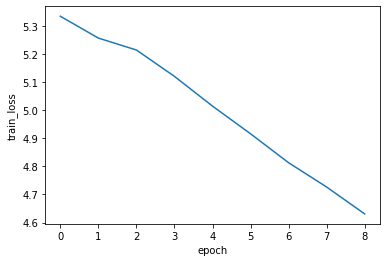

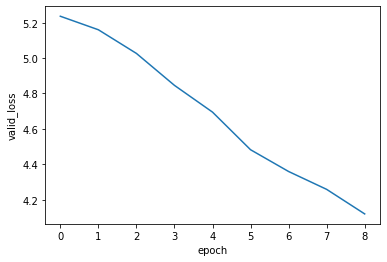

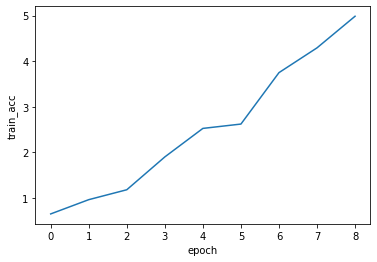

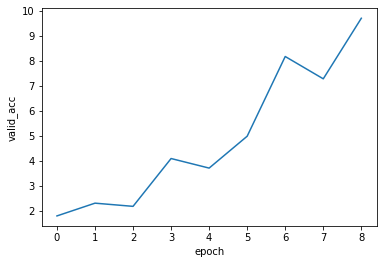

NameError: name 'f1_valid' is not defined

In [46]:
with open("adam_train_loss.txt", "w") as f:
    f.write(json.dumps(train_loss))
with open("adam_valid_loss.txt", "w") as f:
    f.write(json.dumps(valid_loss))
with open("adam_train_acc.txt", "w") as f:
    f.write(json.dumps(train_acc))
with open("adam_valid_acc.txt", "w") as f:
    f.write(json.dumps(valid_acc))
with open("adam_f1_valid.txt", "w") as f:
    f.write(json.dumps(f1_valid))
    
    
import matplotlib.pyplot as plt
plt.plot(train_loss)
plt.ylabel('train_loss')
plt.xlabel('epoch')
plt.show()

import matplotlib.pyplot as plt
plt.plot(valid_loss)
plt.ylabel('valid_loss')
plt.xlabel('epoch')
plt.show()

import matplotlib.pyplot as plt
plt.plot(train_acc)
plt.ylabel('train_acc')
plt.xlabel('epoch')
plt.show()

import matplotlib.pyplot as plt
plt.plot(valid_acc)
plt.ylabel('valid_acc')
plt.xlabel('epoch')
plt.show()

import matplotlib.pyplot as plt
plt.plot(f1_valid)
plt.ylabel('f1_macro_valid')
plt.xlabel('epoch')
plt.show()


### Train data #2 (AdaBound)

In [27]:
model = torchvision.models.vgg16(pretrained=True)
for param in model.parameters():
    param.requires_grad = False
num_ftrs = model.classifier[-1].in_features
model.classifier[-1] = Linear(num_ftrs, 196)
model.classifier[-4] = Linear(4096, 4096)
model.classifier[-7] = Linear(25088, 4096)




device = ('cuda' if torch.cuda.is_available() else 'cpu')
optimizer = AdaBound(model.parameters(), lr=lr)

criterion = CrossEntropyLoss()

model = model.to(device)

train_loss, valid_loss, train_acc, valid_acc, f1_valid = [], [], [], [], []
for epoch in range(epochs):
    print(f"Epoch {epoch+1} of {epochs}")

    
    model.train()
    print('Start training')
    train_running_loss = 0.0
    train_running_correct = 0
    for i, data in tqdm(enumerate(train_data_loader), total=len(train_data_loader)):
        image, labels = data
        image = image.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(image)
        loss = criterion(outputs, labels)
        train_running_loss += loss.item()
        _, preds = torch.max(outputs.data, 1)
        train_running_correct += (preds == labels).sum().item()
        loss.backward()
        optimizer.step()

    train_epoch_loss = train_running_loss / len(train_data_loader)
    train_epoch_acc = 100. * (train_running_correct / len(train_data_loader.dataset))
    
    print(f"Training loss: {train_epoch_loss:.3f}, training acc: {train_epoch_acc:.3f}")
    

    model.eval()
    print('Start validation')
    valid_running_loss = 0.0
    valid_running_correct = 0
    y_preds, y_true = [], []
    with torch.no_grad():
        for i, data in tqdm(enumerate(valid_data_loader), total=len(valid_data_loader)):
            image, labels = data
            image = image.to(device)
            labels = labels.to(device)
            outputs = model(image)
            loss = criterion(outputs, labels)
            valid_running_loss += loss.item()
            _, preds = torch.max(outputs.data, 1)
            y_preds.extend(preds.cpu())
            y_true.extend(labels.data.cpu())
            valid_running_correct += (preds == labels).sum().item()

    valid_epoch_loss = valid_running_loss / len(valid_data_loader)
    valid_epoch_acc = 100. * (valid_running_correct / len(valid_data_loader.dataset))
    f1_e = f1_score(np.array(y_true), np.array(y_preds), average='macro')   
    
    print(f"Validation loss: {valid_epoch_loss:.3f}, validation acc: {valid_epoch_acc:.3f}")
    print(f"f1 for epoch: {f1_e}")
    
    train_loss.append(train_epoch_loss)
    valid_loss.append(valid_epoch_loss)
    f1_valid.append(f1_e)
    train_acc.append(train_epoch_acc)
    valid_acc.append(valid_epoch_acc)
    
    print("____________________")

Epoch 1 of 200
Start training


  0%|          | 0/22 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbb336a78c0>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbb336a78c0>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    if w.is_alive():
  File "/opt/con

Training loss: 5.329, training acc: 0.639
Start validation


  0%|          | 0/3 [00:00<?, ?it/s]

Validation loss: 5.217, validation acc: 1.913
f1 for epoch: 0.012419952482930454
____________________
Epoch 2 of 200
Start training


  0%|          | 0/22 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbb336a78c0>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbb336a78c0>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    if w.is_alive():
  File "/opt/con

Training loss: 5.279, training acc: 0.870
Start validation


  0%|          | 0/3 [00:00<?, ?it/s]

Validation loss: 5.153, validation acc: 1.786
f1 for epoch: 0.004989838314274729
____________________
Epoch 3 of 200
Start training


  0%|          | 0/22 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbb336a78c0>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbb336a78c0>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    if w.is_alive():
  File "/opt/con

Training loss: 5.218, training acc: 1.250
Start validation


  0%|          | 0/3 [00:00<?, ?it/s]

Validation loss: 5.018, validation acc: 2.551
f1 for epoch: 0.013515921219173126
____________________
Epoch 4 of 200
Start training


  0%|          | 0/22 [00:00<?, ?it/s]

Training loss: 5.106, training acc: 1.698
Start validation


  0%|          | 0/3 [00:00<?, ?it/s]

Validation loss: 4.856, validation acc: 4.337
f1 for epoch: 0.021078309105842442
____________________
Epoch 5 of 200
Start training


  0%|          | 0/22 [00:00<?, ?it/s]

Training loss: 5.009, training acc: 2.514
Start validation


  0%|          | 0/3 [00:00<?, ?it/s]

Validation loss: 4.640, validation acc: 3.827
f1 for epoch: 0.021806439464839893
____________________
Epoch 6 of 200
Start training


  0%|          | 0/22 [00:00<?, ?it/s]

Training loss: 4.906, training acc: 2.717
Start validation


  0%|          | 0/3 [00:00<?, ?it/s]

Validation loss: 4.510, validation acc: 5.612
f1 for epoch: 0.035118642303642096
____________________
Epoch 7 of 200
Start training


  0%|          | 0/22 [00:00<?, ?it/s]

Training loss: 4.804, training acc: 3.438
Start validation


  0%|          | 0/3 [00:00<?, ?it/s]

Validation loss: 4.343, validation acc: 7.270
f1 for epoch: 0.041780526954428056
____________________
Epoch 8 of 200
Start training


  0%|          | 0/22 [00:00<?, ?it/s]

Training loss: 4.685, training acc: 4.253
Start validation


  0%|          | 0/3 [00:00<?, ?it/s]

Validation loss: 4.245, validation acc: 7.015
f1 for epoch: 0.04440393002952549
____________________
Epoch 9 of 200
Start training


  0%|          | 0/22 [00:00<?, ?it/s]

Training loss: 4.573, training acc: 5.408
Start validation


  0%|          | 0/3 [00:00<?, ?it/s]

Validation loss: 4.094, validation acc: 9.439
f1 for epoch: 0.05933329522743961
____________________
Epoch 10 of 200
Start training


  0%|          | 0/22 [00:00<?, ?it/s]

Training loss: 4.546, training acc: 5.639
Start validation


  0%|          | 0/3 [00:00<?, ?it/s]

Validation loss: 4.012, validation acc: 9.821
f1 for epoch: 0.0634302980111642
____________________
Epoch 11 of 200
Start training


  0%|          | 0/22 [00:00<?, ?it/s]

Training loss: 4.479, training acc: 6.399
Start validation


  0%|          | 0/3 [00:00<?, ?it/s]

Validation loss: 3.920, validation acc: 11.480
f1 for epoch: 0.0762884453491637
____________________
Epoch 12 of 200
Start training


  0%|          | 0/22 [00:00<?, ?it/s]

Training loss: 4.384, training acc: 7.446
Start validation


  0%|          | 0/3 [00:00<?, ?it/s]

Validation loss: 3.799, validation acc: 13.265
f1 for epoch: 0.10192215494168552
____________________
Epoch 13 of 200
Start training


  0%|          | 0/22 [00:00<?, ?it/s]

Training loss: 4.332, training acc: 7.935
Start validation


  0%|          | 0/3 [00:00<?, ?it/s]

Validation loss: 3.696, validation acc: 14.031
f1 for epoch: 0.10483089285191838
____________________
Epoch 14 of 200
Start training


  0%|          | 0/22 [00:00<?, ?it/s]

Training loss: 4.270, training acc: 8.424
Start validation


  0%|          | 0/3 [00:00<?, ?it/s]

Validation loss: 3.622, validation acc: 15.179
f1 for epoch: 0.12512300362299444
____________________
Epoch 15 of 200
Start training


  0%|          | 0/22 [00:00<?, ?it/s]

Training loss: 4.206, training acc: 8.478
Start validation


  0%|          | 0/3 [00:00<?, ?it/s]

Validation loss: 3.580, validation acc: 15.306
f1 for epoch: 0.11512424814554877
____________________
Epoch 16 of 200
Start training


  0%|          | 0/22 [00:00<?, ?it/s]

Training loss: 4.169, training acc: 10.095
Start validation


  0%|          | 0/3 [00:00<?, ?it/s]

Validation loss: 3.519, validation acc: 16.199
f1 for epoch: 0.1374284146844869
____________________
Epoch 17 of 200
Start training


  0%|          | 0/22 [00:00<?, ?it/s]

Training loss: 4.118, training acc: 10.095
Start validation


  0%|          | 0/3 [00:00<?, ?it/s]

Validation loss: 3.443, validation acc: 17.474
f1 for epoch: 0.15009184897923708
____________________
Epoch 18 of 200
Start training


  0%|          | 0/22 [00:00<?, ?it/s]

Training loss: 4.027, training acc: 11.481
Start validation


  0%|          | 0/3 [00:00<?, ?it/s]

Validation loss: 3.368, validation acc: 19.898
f1 for epoch: 0.16682473322329264
____________________
Epoch 19 of 200
Start training


  0%|          | 0/22 [00:00<?, ?it/s]

Training loss: 3.947, training acc: 11.644
Start validation


  0%|          | 0/3 [00:00<?, ?it/s]

Validation loss: 3.356, validation acc: 19.133
f1 for epoch: 0.15840722950994346
____________________
Epoch 20 of 200
Start training


  0%|          | 0/22 [00:00<?, ?it/s]

Training loss: 3.945, training acc: 12.446
Start validation


  0%|          | 0/3 [00:00<?, ?it/s]

Validation loss: 3.276, validation acc: 19.770
f1 for epoch: 0.17636362789439464
____________________
Epoch 21 of 200
Start training


  0%|          | 0/22 [00:00<?, ?it/s]

Training loss: 3.943, training acc: 13.043
Start validation


  0%|          | 0/3 [00:00<?, ?it/s]

Validation loss: 3.293, validation acc: 18.240
f1 for epoch: 0.15085057725265125
____________________
Epoch 22 of 200
Start training


  0%|          | 0/22 [00:00<?, ?it/s]

Training loss: 3.900, training acc: 13.696
Start validation


  0%|          | 0/3 [00:00<?, ?it/s]

Validation loss: 3.290, validation acc: 19.515
f1 for epoch: 0.16591970862203895
____________________
Epoch 23 of 200
Start training


  0%|          | 0/22 [00:00<?, ?it/s]

Training loss: 3.825, training acc: 14.796
Start validation


  0%|          | 0/3 [00:00<?, ?it/s]

Validation loss: 3.167, validation acc: 22.832
f1 for epoch: 0.19333057582883828
____________________
Epoch 24 of 200
Start training


  0%|          | 0/22 [00:00<?, ?it/s]

Training loss: 3.828, training acc: 14.932
Start validation


  0%|          | 0/3 [00:00<?, ?it/s]

Validation loss: 3.126, validation acc: 22.321
f1 for epoch: 0.19184725267676872
____________________
Epoch 25 of 200
Start training


  0%|          | 0/22 [00:00<?, ?it/s]

Training loss: 3.757, training acc: 14.470
Start validation


  0%|          | 0/3 [00:00<?, ?it/s]

Validation loss: 3.100, validation acc: 23.597
f1 for epoch: 0.20058100736190393
____________________
Epoch 26 of 200
Start training


  0%|          | 0/22 [00:00<?, ?it/s]

Training loss: 3.745, training acc: 15.815
Start validation


  0%|          | 0/3 [00:00<?, ?it/s]

Validation loss: 3.050, validation acc: 23.597
f1 for epoch: 0.19593662103398835
____________________
Epoch 27 of 200
Start training


  0%|          | 0/22 [00:00<?, ?it/s]

Training loss: 3.746, training acc: 16.019
Start validation


  0%|          | 0/3 [00:00<?, ?it/s]

Validation loss: 3.036, validation acc: 22.449
f1 for epoch: 0.18389237833378463
____________________
Epoch 28 of 200
Start training


  0%|          | 0/22 [00:00<?, ?it/s]

Training loss: 3.720, training acc: 16.046
Start validation


  0%|          | 0/3 [00:00<?, ?it/s]

Validation loss: 2.976, validation acc: 25.383
f1 for epoch: 0.2291493144768368
____________________
Epoch 29 of 200
Start training


  0%|          | 0/22 [00:00<?, ?it/s]

Training loss: 3.621, training acc: 17.079
Start validation


  0%|          | 0/3 [00:00<?, ?it/s]

Validation loss: 2.970, validation acc: 24.362
f1 for epoch: 0.2153500593134537
____________________
Epoch 30 of 200
Start training


  0%|          | 0/22 [00:00<?, ?it/s]

Training loss: 3.580, training acc: 17.840
Start validation


  0%|          | 0/3 [00:00<?, ?it/s]

Validation loss: 2.962, validation acc: 26.913
f1 for epoch: 0.23749627291744368
____________________
Epoch 31 of 200
Start training


  0%|          | 0/22 [00:00<?, ?it/s]

Training loss: 3.576, training acc: 18.356
Start validation


  0%|          | 0/3 [00:00<?, ?it/s]

Validation loss: 2.967, validation acc: 26.020
f1 for epoch: 0.24127855816206745
____________________
Epoch 32 of 200
Start training


  0%|          | 0/22 [00:00<?, ?it/s]

Training loss: 3.521, training acc: 18.750
Start validation


  0%|          | 0/3 [00:00<?, ?it/s]

Validation loss: 2.887, validation acc: 27.168
f1 for epoch: 0.2440167912848192
____________________
Epoch 33 of 200
Start training


  0%|          | 0/22 [00:00<?, ?it/s]

Training loss: 3.500, training acc: 19.266
Start validation


  0%|          | 0/3 [00:00<?, ?it/s]

Validation loss: 2.834, validation acc: 29.719
f1 for epoch: 0.26197730717473394
____________________
Epoch 34 of 200
Start training


  0%|          | 0/22 [00:00<?, ?it/s]

Training loss: 3.437, training acc: 19.796
Start validation


  0%|          | 0/3 [00:00<?, ?it/s]

Validation loss: 2.805, validation acc: 26.276
f1 for epoch: 0.23697385604609023
____________________
Epoch 35 of 200
Start training


  0%|          | 0/22 [00:00<?, ?it/s]

Training loss: 3.451, training acc: 19.226
Start validation


  0%|          | 0/3 [00:00<?, ?it/s]

Validation loss: 2.809, validation acc: 29.082
f1 for epoch: 0.26425512762547576
____________________
Epoch 36 of 200
Start training


  0%|          | 0/22 [00:00<?, ?it/s]

Training loss: 3.418, training acc: 20.598
Start validation


  0%|          | 0/3 [00:00<?, ?it/s]

Validation loss: 2.837, validation acc: 28.316
f1 for epoch: 0.24774720526275726
____________________
Epoch 37 of 200
Start training


  0%|          | 0/22 [00:00<?, ?it/s]

Training loss: 3.327, training acc: 21.807
Start validation


  0%|          | 0/3 [00:00<?, ?it/s]

Validation loss: 2.791, validation acc: 29.082
f1 for epoch: 0.2614654531258999
____________________
Epoch 38 of 200
Start training


  0%|          | 0/22 [00:00<?, ?it/s]

Training loss: 3.337, training acc: 21.753
Start validation


  0%|          | 0/3 [00:00<?, ?it/s]

Validation loss: 2.820, validation acc: 28.189
f1 for epoch: 0.2523005041264977
____________________
Epoch 39 of 200
Start training


  0%|          | 0/22 [00:00<?, ?it/s]

Training loss: 3.300, training acc: 22.948
Start validation


  0%|          | 0/3 [00:00<?, ?it/s]

Validation loss: 2.738, validation acc: 30.357
f1 for epoch: 0.2755650103426056
____________________
Epoch 40 of 200
Start training


  0%|          | 0/22 [00:00<?, ?it/s]

Training loss: 3.307, training acc: 22.527
Start validation


  0%|          | 0/3 [00:00<?, ?it/s]

Validation loss: 2.725, validation acc: 28.827
f1 for epoch: 0.25672164893461535
____________________
Epoch 41 of 200
Start training


  0%|          | 0/22 [00:00<?, ?it/s]

Training loss: 3.266, training acc: 23.016
Start validation


  0%|          | 0/3 [00:00<?, ?it/s]

Validation loss: 2.694, validation acc: 30.102
f1 for epoch: 0.2732272530839784
____________________
Epoch 42 of 200
Start training


  0%|          | 0/22 [00:00<?, ?it/s]

Training loss: 3.273, training acc: 22.636
Start validation


  0%|          | 0/3 [00:00<?, ?it/s]

Validation loss: 2.675, validation acc: 30.102
f1 for epoch: 0.2748921599812414
____________________
Epoch 43 of 200
Start training


  0%|          | 0/22 [00:00<?, ?it/s]

Training loss: 3.290, training acc: 23.016
Start validation


  0%|          | 0/3 [00:00<?, ?it/s]

Validation loss: 2.661, validation acc: 30.485
f1 for epoch: 0.28474705899675884
____________________
Epoch 44 of 200
Start training


  0%|          | 0/22 [00:00<?, ?it/s]

Training loss: 3.198, training acc: 23.927
Start validation


  0%|          | 0/3 [00:00<?, ?it/s]

Validation loss: 2.658, validation acc: 30.485
f1 for epoch: 0.2876315258651614
____________________
Epoch 45 of 200
Start training


  0%|          | 0/22 [00:00<?, ?it/s]

Training loss: 3.216, training acc: 23.899
Start validation


  0%|          | 0/3 [00:00<?, ?it/s]

Validation loss: 2.627, validation acc: 32.781
f1 for epoch: 0.30503223184045514
____________________
Epoch 46 of 200
Start training


  0%|          | 0/22 [00:00<?, ?it/s]

Training loss: 3.188, training acc: 25.299
Start validation


  0%|          | 0/3 [00:00<?, ?it/s]

Validation loss: 2.560, validation acc: 32.781
f1 for epoch: 0.29951622923561694
____________________
Epoch 47 of 200
Start training


  0%|          | 0/22 [00:00<?, ?it/s]

Training loss: 3.126, training acc: 25.720
Start validation


  0%|          | 0/3 [00:00<?, ?it/s]

Validation loss: 2.622, validation acc: 31.888
f1 for epoch: 0.29848348532559055
____________________
Epoch 48 of 200
Start training


  0%|          | 0/22 [00:00<?, ?it/s]

Training loss: 3.135, training acc: 25.299
Start validation


  0%|          | 0/3 [00:00<?, ?it/s]

Validation loss: 2.617, validation acc: 29.847
f1 for epoch: 0.27603556819611663
____________________
Epoch 49 of 200
Start training


  0%|          | 0/22 [00:00<?, ?it/s]

Training loss: 3.133, training acc: 26.073
Start validation


  0%|          | 0/3 [00:00<?, ?it/s]

Validation loss: 2.593, validation acc: 34.949
f1 for epoch: 0.3282394790538208
____________________
Epoch 50 of 200
Start training


  0%|          | 0/22 [00:00<?, ?it/s]

Training loss: 3.137, training acc: 25.761
Start validation


  0%|          | 0/3 [00:00<?, ?it/s]

Validation loss: 2.652, validation acc: 30.995
f1 for epoch: 0.28347111339584646
____________________
Epoch 51 of 200
Start training


  0%|          | 0/22 [00:00<?, ?it/s]

Training loss: 3.129, training acc: 26.549
Start validation


  0%|          | 0/3 [00:00<?, ?it/s]

Validation loss: 2.577, validation acc: 34.056
f1 for epoch: 0.32180687951876286
____________________
Epoch 52 of 200
Start training


  0%|          | 0/22 [00:00<?, ?it/s]

Training loss: 3.125, training acc: 27.323
Start validation


  0%|          | 0/3 [00:00<?, ?it/s]

Validation loss: 2.541, validation acc: 35.332
f1 for epoch: 0.33019145343259193
____________________
Epoch 53 of 200
Start training


  0%|          | 0/22 [00:00<?, ?it/s]

Training loss: 3.080, training acc: 27.486
Start validation


  0%|          | 0/3 [00:00<?, ?it/s]

Validation loss: 2.535, validation acc: 34.056
f1 for epoch: 0.31412621592970047
____________________
Epoch 54 of 200
Start training


  0%|          | 0/22 [00:00<?, ?it/s]

Training loss: 3.093, training acc: 26.413
Start validation


  0%|          | 0/3 [00:00<?, ?it/s]

Validation loss: 2.501, validation acc: 33.801
f1 for epoch: 0.31270141107602406
____________________
Epoch 55 of 200
Start training


  0%|          | 0/22 [00:00<?, ?it/s]

Training loss: 3.063, training acc: 27.500
Start validation


  0%|          | 0/3 [00:00<?, ?it/s]

Validation loss: 2.535, validation acc: 33.163
f1 for epoch: 0.3089679371231466
____________________
Epoch 56 of 200
Start training


  0%|          | 0/22 [00:00<?, ?it/s]

Training loss: 3.020, training acc: 28.207
Start validation


  0%|          | 0/3 [00:00<?, ?it/s]

Validation loss: 2.509, validation acc: 34.949
f1 for epoch: 0.3317277801896649
____________________
Epoch 57 of 200
Start training


  0%|          | 0/22 [00:00<?, ?it/s]

Training loss: 2.974, training acc: 28.981
Start validation


  0%|          | 0/3 [00:00<?, ?it/s]

Validation loss: 2.499, validation acc: 34.821
f1 for epoch: 0.32523897000305985
____________________
Epoch 58 of 200
Start training


  0%|          | 0/22 [00:00<?, ?it/s]

Training loss: 3.023, training acc: 28.492
Start validation


  0%|          | 0/3 [00:00<?, ?it/s]

Validation loss: 2.499, validation acc: 36.224
f1 for epoch: 0.3435128992251211
____________________
Epoch 59 of 200
Start training


  0%|          | 0/22 [00:00<?, ?it/s]

Training loss: 2.999, training acc: 29.144
Start validation


  0%|          | 0/3 [00:00<?, ?it/s]

Validation loss: 2.470, validation acc: 35.077
f1 for epoch: 0.32841711714728306
____________________
Epoch 60 of 200
Start training


  0%|          | 0/22 [00:00<?, ?it/s]

Training loss: 2.972, training acc: 30.014
Start validation


  0%|          | 0/3 [00:00<?, ?it/s]

Validation loss: 2.478, validation acc: 36.735
f1 for epoch: 0.34089515759683825
____________________
Epoch 61 of 200
Start training


  0%|          | 0/22 [00:00<?, ?it/s]

Training loss: 2.950, training acc: 29.538
Start validation


  0%|          | 0/3 [00:00<?, ?it/s]

Validation loss: 2.455, validation acc: 37.372
f1 for epoch: 0.3552634931761582
____________________
Epoch 62 of 200
Start training


  0%|          | 0/22 [00:00<?, ?it/s]

Training loss: 2.927, training acc: 30.435
Start validation


  0%|          | 0/3 [00:00<?, ?it/s]

Validation loss: 2.472, validation acc: 35.459
f1 for epoch: 0.33532203340876804
____________________
Epoch 63 of 200
Start training


  0%|          | 0/22 [00:00<?, ?it/s]

Training loss: 2.938, training acc: 30.774
Start validation


  0%|          | 0/3 [00:00<?, ?it/s]

Validation loss: 2.472, validation acc: 35.204
f1 for epoch: 0.3368741802415272
____________________
Epoch 64 of 200
Start training


  0%|          | 0/22 [00:00<?, ?it/s]

Training loss: 2.873, training acc: 30.639
Start validation


  0%|          | 0/3 [00:00<?, ?it/s]

Validation loss: 2.465, validation acc: 36.862
f1 for epoch: 0.34264293064089296
____________________
Epoch 65 of 200
Start training


  0%|          | 0/22 [00:00<?, ?it/s]

Training loss: 2.911, training acc: 30.204
Start validation


  0%|          | 0/3 [00:00<?, ?it/s]

Validation loss: 2.463, validation acc: 36.224
f1 for epoch: 0.34123601184382013
____________________
Epoch 66 of 200
Start training


  0%|          | 0/22 [00:00<?, ?it/s]

Training loss: 2.892, training acc: 31.182
Start validation


  0%|          | 0/3 [00:00<?, ?it/s]

Validation loss: 2.424, validation acc: 36.735
f1 for epoch: 0.3468853485099457
____________________
Epoch 67 of 200
Start training


  0%|          | 0/22 [00:00<?, ?it/s]

Training loss: 2.840, training acc: 30.679
Start validation


  0%|          | 0/3 [00:00<?, ?it/s]

Validation loss: 2.418, validation acc: 35.842
f1 for epoch: 0.33373953053251837
____________________
Epoch 68 of 200
Start training


  0%|          | 0/22 [00:00<?, ?it/s]

Training loss: 2.846, training acc: 31.780
Start validation


  0%|          | 0/3 [00:00<?, ?it/s]

Validation loss: 2.405, validation acc: 37.755
f1 for epoch: 0.3546610904275709
____________________
Epoch 69 of 200
Start training


  0%|          | 0/22 [00:00<?, ?it/s]

Training loss: 2.844, training acc: 31.128
Start validation


  0%|          | 0/3 [00:00<?, ?it/s]

Validation loss: 2.375, validation acc: 38.265
f1 for epoch: 0.358523780763861
____________________
Epoch 70 of 200
Start training


  0%|          | 0/22 [00:00<?, ?it/s]

Training loss: 2.812, training acc: 32.024
Start validation


  0%|          | 0/3 [00:00<?, ?it/s]

Validation loss: 2.410, validation acc: 39.286
f1 for epoch: 0.3747218367866627
____________________
Epoch 71 of 200
Start training


  0%|          | 0/22 [00:00<?, ?it/s]

Training loss: 2.749, training acc: 32.989
Start validation


  0%|          | 0/3 [00:00<?, ?it/s]

Validation loss: 2.395, validation acc: 38.393
f1 for epoch: 0.3696224158449209
____________________
Epoch 72 of 200
Start training


  0%|          | 0/22 [00:00<?, ?it/s]

Training loss: 2.762, training acc: 33.071
Start validation


  0%|          | 0/3 [00:00<?, ?it/s]

Validation loss: 2.380, validation acc: 38.265
f1 for epoch: 0.36239726677428075
____________________
Epoch 73 of 200
Start training


  0%|          | 0/22 [00:00<?, ?it/s]

Training loss: 2.730, training acc: 33.777
Start validation


  0%|          | 0/3 [00:00<?, ?it/s]

Validation loss: 2.400, validation acc: 37.117
f1 for epoch: 0.3514684803325259
____________________
Epoch 74 of 200
Start training


  0%|          | 0/22 [00:00<?, ?it/s]

Training loss: 2.711, training acc: 33.315
Start validation


  0%|          | 0/3 [00:00<?, ?it/s]

Validation loss: 2.383, validation acc: 38.393
f1 for epoch: 0.3606379589797956
____________________
Epoch 75 of 200
Start training


  0%|          | 0/22 [00:00<?, ?it/s]

Training loss: 2.669, training acc: 34.307
Start validation


  0%|          | 0/3 [00:00<?, ?it/s]

Validation loss: 2.401, validation acc: 36.862
f1 for epoch: 0.34442475297659475
____________________
Epoch 76 of 200
Start training


  0%|          | 0/22 [00:00<?, ?it/s]

Training loss: 2.665, training acc: 34.579
Start validation


  0%|          | 0/3 [00:00<?, ?it/s]

Validation loss: 2.394, validation acc: 36.097
f1 for epoch: 0.34443644949985874
____________________
Epoch 77 of 200
Start training


  0%|          | 0/22 [00:00<?, ?it/s]

Training loss: 2.690, training acc: 35.897
Start validation


  0%|          | 0/3 [00:00<?, ?it/s]

Validation loss: 2.392, validation acc: 37.755
f1 for epoch: 0.35502870700949934
____________________
Epoch 78 of 200
Start training


  0%|          | 0/22 [00:00<?, ?it/s]

Training loss: 2.711, training acc: 34.130
Start validation


  0%|          | 0/3 [00:00<?, ?it/s]

Validation loss: 2.421, validation acc: 36.862
f1 for epoch: 0.34903741633183405
____________________
Epoch 79 of 200
Start training


  0%|          | 0/22 [00:00<?, ?it/s]

Training loss: 2.701, training acc: 35.394
Start validation


  0%|          | 0/3 [00:00<?, ?it/s]

Validation loss: 2.336, validation acc: 37.245
f1 for epoch: 0.35149518098947863
____________________
Epoch 80 of 200
Start training


  0%|          | 0/22 [00:00<?, ?it/s]

Training loss: 2.689, training acc: 34.443
Start validation


  0%|          | 0/3 [00:00<?, ?it/s]

Validation loss: 2.392, validation acc: 38.903
f1 for epoch: 0.3750443434116903
____________________
Epoch 81 of 200
Start training


  0%|          | 0/22 [00:00<?, ?it/s]

Training loss: 2.656, training acc: 34.796
Start validation


  0%|          | 0/3 [00:00<?, ?it/s]

Validation loss: 2.385, validation acc: 36.607
f1 for epoch: 0.35014779050761863
____________________
Epoch 82 of 200
Start training


  0%|          | 0/22 [00:00<?, ?it/s]

Training loss: 2.657, training acc: 35.625
Start validation


  0%|          | 0/3 [00:00<?, ?it/s]

Validation loss: 2.384, validation acc: 37.372
f1 for epoch: 0.34797835188653986
____________________
Epoch 83 of 200
Start training


  0%|          | 0/22 [00:00<?, ?it/s]

Training loss: 2.616, training acc: 35.707
Start validation


  0%|          | 0/3 [00:00<?, ?it/s]

Validation loss: 2.330, validation acc: 38.393
f1 for epoch: 0.3636418595077058
____________________
Epoch 84 of 200
Start training


  0%|          | 0/22 [00:00<?, ?it/s]

Training loss: 2.648, training acc: 35.435
Start validation


  0%|          | 0/3 [00:00<?, ?it/s]

Validation loss: 2.342, validation acc: 39.796
f1 for epoch: 0.3771176652479173
____________________
Epoch 85 of 200
Start training


  0%|          | 0/22 [00:00<?, ?it/s]

Training loss: 2.549, training acc: 37.527
Start validation


  0%|          | 0/3 [00:00<?, ?it/s]

Validation loss: 2.330, validation acc: 38.776
f1 for epoch: 0.3693154942629732
____________________
Epoch 86 of 200
Start training


  0%|          | 0/22 [00:00<?, ?it/s]

Training loss: 2.526, training acc: 37.024
Start validation


  0%|          | 0/3 [00:00<?, ?it/s]

Validation loss: 2.333, validation acc: 39.668
f1 for epoch: 0.37702869692665614
____________________
Epoch 87 of 200
Start training


  0%|          | 0/22 [00:00<?, ?it/s]

Training loss: 2.520, training acc: 37.812
Start validation


  0%|          | 0/3 [00:00<?, ?it/s]

Validation loss: 2.401, validation acc: 38.648
f1 for epoch: 0.3729160725930486
____________________
Epoch 88 of 200
Start training


  0%|          | 0/22 [00:00<?, ?it/s]

Training loss: 2.633, training acc: 36.753
Start validation


  0%|          | 0/3 [00:00<?, ?it/s]

Validation loss: 2.352, validation acc: 39.541
f1 for epoch: 0.3731841571127285
____________________
Epoch 89 of 200
Start training


  0%|          | 0/22 [00:00<?, ?it/s]

Training loss: 2.582, training acc: 36.766
Start validation


  0%|          | 0/3 [00:00<?, ?it/s]

Validation loss: 2.398, validation acc: 39.796
f1 for epoch: 0.379152706703727
____________________
Epoch 90 of 200
Start training


  0%|          | 0/22 [00:00<?, ?it/s]

Training loss: 2.535, training acc: 37.351
Start validation


  0%|          | 0/3 [00:00<?, ?it/s]

Validation loss: 2.377, validation acc: 38.138
f1 for epoch: 0.366717565314504
____________________
Epoch 91 of 200
Start training


  0%|          | 0/22 [00:00<?, ?it/s]

Training loss: 2.488, training acc: 37.541
Start validation


  0%|          | 0/3 [00:00<?, ?it/s]

Validation loss: 2.382, validation acc: 37.883
f1 for epoch: 0.36235189796864464
____________________
Epoch 92 of 200
Start training


  0%|          | 0/22 [00:00<?, ?it/s]

Training loss: 2.495, training acc: 38.152
Start validation


  0%|          | 0/3 [00:00<?, ?it/s]

Validation loss: 2.316, validation acc: 38.265
f1 for epoch: 0.36939422538912337
____________________
Epoch 93 of 200
Start training


  0%|          | 0/22 [00:00<?, ?it/s]

Training loss: 2.479, training acc: 37.908
Start validation


  0%|          | 0/3 [00:00<?, ?it/s]

Validation loss: 2.354, validation acc: 40.689
f1 for epoch: 0.38931711563290516
____________________
Epoch 94 of 200
Start training


  0%|          | 0/22 [00:00<?, ?it/s]

Training loss: 2.463, training acc: 39.321
Start validation


  0%|          | 0/3 [00:00<?, ?it/s]

Validation loss: 2.287, validation acc: 41.709
f1 for epoch: 0.4033930840575237
____________________
Epoch 95 of 200
Start training


  0%|          | 0/22 [00:00<?, ?it/s]

Training loss: 2.415, training acc: 39.090
Start validation


  0%|          | 0/3 [00:00<?, ?it/s]

Validation loss: 2.272, validation acc: 39.541
f1 for epoch: 0.38115346433015607
____________________
Epoch 96 of 200
Start training


  0%|          | 0/22 [00:00<?, ?it/s]

Training loss: 2.431, training acc: 39.755
Start validation


  0%|          | 0/3 [00:00<?, ?it/s]

Validation loss: 2.286, validation acc: 41.199
f1 for epoch: 0.39588393465944477
____________________
Epoch 97 of 200
Start training


  0%|          | 0/22 [00:00<?, ?it/s]

Training loss: 2.475, training acc: 38.995
Start validation


  0%|          | 0/3 [00:00<?, ?it/s]

Validation loss: 2.269, validation acc: 40.051
f1 for epoch: 0.3846803497850758
____________________
Epoch 98 of 200
Start training


  0%|          | 0/22 [00:00<?, ?it/s]

Training loss: 2.462, training acc: 38.818
Start validation


  0%|          | 0/3 [00:00<?, ?it/s]

Validation loss: 2.348, validation acc: 40.306
f1 for epoch: 0.3758537640918225
____________________
Epoch 99 of 200
Start training


  0%|          | 0/22 [00:00<?, ?it/s]

Training loss: 2.429, training acc: 38.587
Start validation


  0%|          | 0/3 [00:00<?, ?it/s]

Validation loss: 2.324, validation acc: 42.730
f1 for epoch: 0.4054201150989866
____________________
Epoch 100 of 200
Start training


  0%|          | 0/22 [00:00<?, ?it/s]

Training loss: 2.440, training acc: 39.647
Start validation


  0%|          | 0/3 [00:00<?, ?it/s]

Validation loss: 2.283, validation acc: 42.219
f1 for epoch: 0.4038070631182876
____________________
Epoch 101 of 200
Start training


  0%|          | 0/22 [00:00<?, ?it/s]

KeyboardInterrupt: 

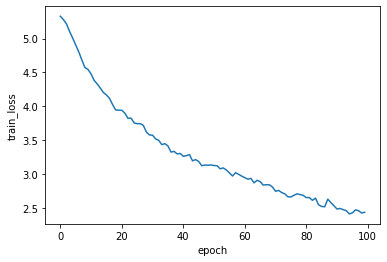

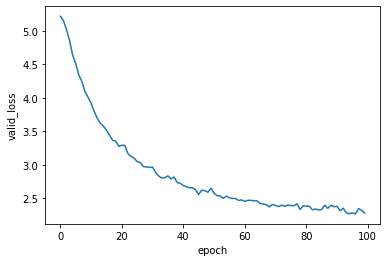

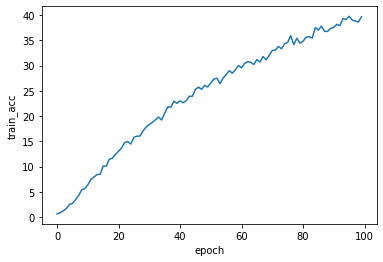

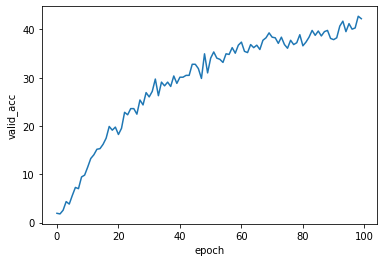

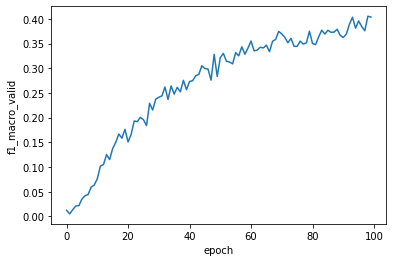

In [28]:
with open("adam_train_loss.txt", "w") as f:
    f.write(json.dumps(train_loss))
with open("adam_valid_loss.txt", "w") as f:
    f.write(json.dumps(valid_loss))
with open("adam_train_acc.txt", "w") as f:
    f.write(json.dumps(train_acc))
with open("adam_valid_acc.txt", "w") as f:
    f.write(json.dumps(valid_acc))
with open("adam_f1_valid.txt", "w") as f:
    f.write(json.dumps(f1_valid))
    
    
import matplotlib.pyplot as plt
plt.plot(train_loss)
plt.ylabel('train_loss')
plt.xlabel('epoch')
plt.show()

import matplotlib.pyplot as plt
plt.plot(valid_loss)
plt.ylabel('valid_loss')
plt.xlabel('epoch')
plt.show()

import matplotlib.pyplot as plt
plt.plot(train_acc)
plt.ylabel('train_acc')
plt.xlabel('epoch')
plt.show()

import matplotlib.pyplot as plt
plt.plot(valid_acc)
plt.ylabel('valid_acc')
plt.xlabel('epoch')
plt.show()

import matplotlib.pyplot as plt
plt.plot(f1_valid)
plt.ylabel('f1_macro_valid')
plt.xlabel('epoch')
plt.show()